In [2]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## batch sizes

Running baseline scenario with batch sizes 512, 1024, 2048 and 4096 using networks unchanged from [1].

A batch-size of 1024 showed the best trade-off between time taken to accrue enough samples in the experience replay buffer to begin policy updates, and time taken to converge on interesting (high reward) policies.

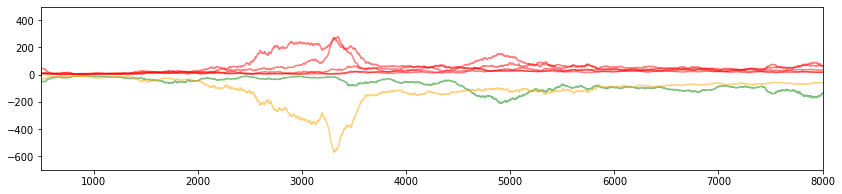

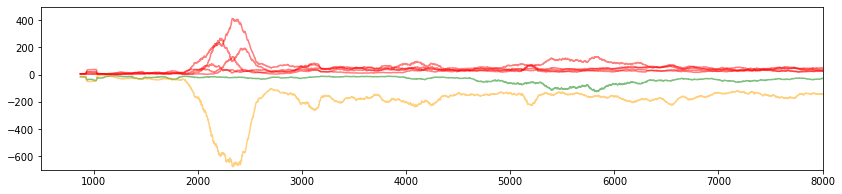

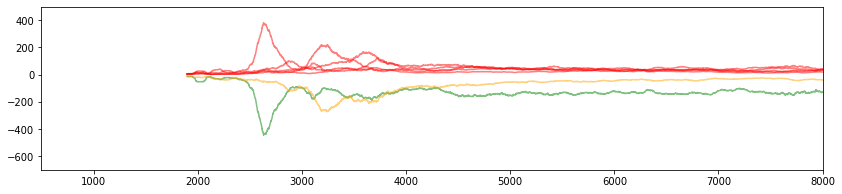

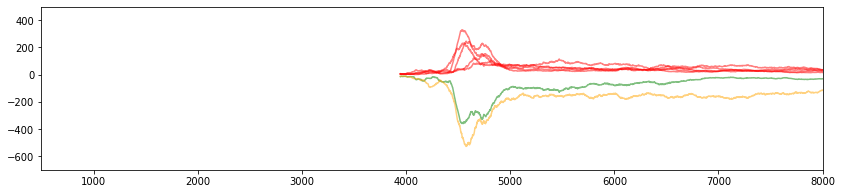

In [87]:
max_episode_len = 100
save_rate = 50
smoothing = 100
colors = ['green', 'orange', 'red', 'red', 'red', 'red', 'red']
for batch_size in [512, 1024, 2048, 4096]:
    offset = batch_size - max_episode_len - save_rate
    rewards = pkl.load(open(f"learning_curves/batch_size/baseline-{batch_size}_rewards.pkl", 'rb'))
    fig = plt.figure(figsize=(14,3))
    for i in range(rewards.shape[1]):
        x = range(rewards.shape[0] - smoothing + 1)[offset:]
        y = moving_average(rewards[:, i], smoothing)[offset:]
        c = colors[i]
        plt.ylim(-700, 500)
        plt.xlim(500, 8000)
        plt.plot(x, y, color=c, alpha=.5)
    plt.show()

In [5]:
r = pkl.load(open(f"learning_curves/anon-0_bite.pkl", 'rb'))
#     r = r.reshape((1, *r.shape))
#     if i == 0:
#         rewards = r
#     else:
#         rewards = np.concatenate((rewards, r), axis=0)

# human_rew, zombie_rew = rewards[:, :, :2], rewards[:, :, 2:]

In [6]:
r.shape

(10000, 7, 7)

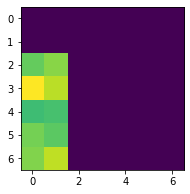

In [8]:
fig = plt.figure(figsize=((12, 3)))
plt.imshow(np.mean(r, axis=0))
# plt.plot(moving_average(r[:, 0, 1], 50))
# plt.hist(r)
plt.show()


## Baseline scenario

### environment

... number, physics, reward function, observation space, action space

### evolution of strategies

In a single experiment we observed learning converging through different pathways of collective behaviours due to random factors.

Dominant play strategies (crowding a single human, or focusing on the lone human) emerge in different agents at different times across multiple runs, but would often follow distinct steps:

#### Brownian motion

Agents move randomly and occasionally collide.

#### Wall hugging

Agents act on the bias of their experience, which in the earlier instances leads them in a cardinal direction until the reach a wall, which neutralises the bias and relies on random motion for further learning.

#### Axis alignment

The initial bias is corrected, and zombies follow humans vertically or horizontally depending on which has the greater reward in their experience. Occasional collisions occur.

#### Persuit

Zombies follow humans through both axes, minimizing their relative distance. At this stage each zombie has experienced more reward from one human than the other, so each fixate on a specific human. Because there are five zombies the selection of target humans is uneven, leading to a lucky and unlucky human who develop different behaviours in response.

#### Lucky human - avoidance

The lucky human often chased by a single zombie, but occasionally will suffer two. Lucky humans learn to stay away from the unlucky human attendant zombies to avoid accidental collision. Occasionally a lucky human will chance a collision with the main swarm to escape their dedicated persuers, often without injury (the main swarm are chasing the unlucky human). The lucky human's strategy doesn't change beyond this point.

#### Unlucky human - breakout

The unlucky human learns to avoid getting boxed in by the main swarm and ignores the lucky human and their followers. Unlucky humans initially have a policy of maximum speed in the direction away from the swarm, largely ignoring walls. On reaching a wall the human will bounce off with no loss of speed and lose reward by breaking through the group of zombies before repeating the cycle.

#### Unlucky human - wall games

From the breakout strategy, the unlucky human learns to effectively dodge following the bounce, then begins to minimize wall collisions (which the zombies and learned to take advantage of) when a safer option is to quickly change direction. As humans have slighly higher acceleration than zombies, this allows the unlucky human to learn to lead zombies to walls at angles allow an escape through an opening. The unlucky human and their entourage reach an equilibruim and specialise within this sub-game to the point where the human sometimes "fakes" a direction of escape once or twice to open up a space when the zombies react to the velocity change. In the case where no easy exit is available the human will revert to the breakout strategy.

#### Target changes - bad luck is contagious

Occasionally we observe a zombie chasing the unlucky human choosing to target the lucky human. This occurs when there have been enough chance collisions with the lucky human for the zombie's taste preference (reward expectation) to shift to a comparitively easier target. The indiscriminate zombie will still occasionally persue an easy collision with their original target as the opportunity presents, but will otherwise focus on the lucky human. The lucky human is now slighly less lucky, and will start to progress through learning strategies similar to the unlucky human. We have not run experiments for enough episodes to determine if the zombie target choice is bistable as a group, or if zombies are universally unfaithful to their humans given enough time.

#### Simulation issues

The zombie fixation on a specific human leads to specialised policies within lucky and unlucky groups. We expect zombies to be exchangeable from the perspective of humans as far as reward goes, and vice versa. A zombie chasing a distant human should not ignore a nearby human.

In [26]:
rewards = None
for i in range(6):
    if i == 5: continue
    r = pkl.load(open(f"learning_curves/health-{i}_rewards.pkl", 'rb'))
    r = r.reshape((1, *r.shape))
    if i == 0:
        rewards = r
    else:
        rewards = np.concatenate((rewards, r), axis=0)

human_rew, zombie_rew = rewards[:, :, :2], rewards[:, :, 2:]

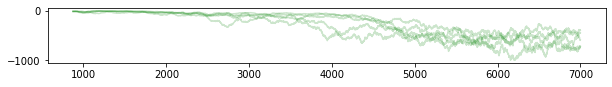

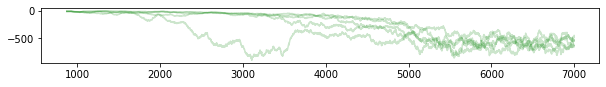

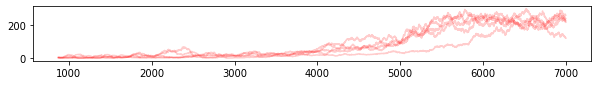

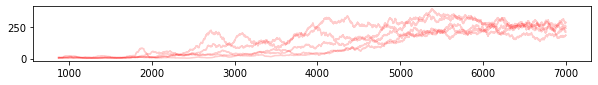

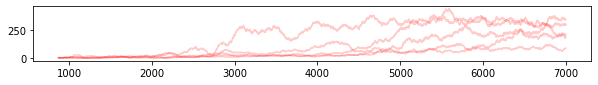

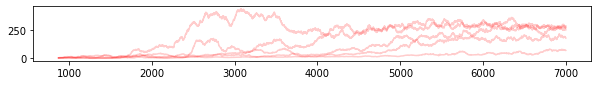

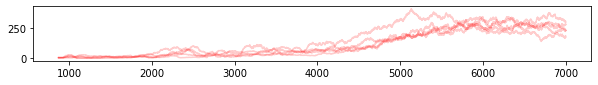

In [27]:
max_episode_len = 100
save_rate = 50
smoothing = 100
batch_size = 1024

for i in range(human_rew.shape[2]):
    offset = batch_size - max_episode_len - save_rate
    fig = plt.figure(figsize=(10,1))
    for j in range(human_rew.shape[0]):
        x = range(human_rew.shape[1] - smoothing + 1)[offset:7000]
        y = moving_average(human_rew[j, :, i], smoothing)[offset:7000]
        plt.plot(x, y, alpha=.2, color='green')
    plt.show()

for i in range(zombie_rew.shape[2]):
    offset = batch_size - max_episode_len - save_rate
    fig = plt.figure(figsize=(10,1))
    for j in range(zombie_rew.shape[0]):
        x = range(zombie_rew.shape[1] - smoothing + 1)[offset:7000]
        y = moving_average(zombie_rew[j, :, i], smoothing)[offset:7000]
        plt.plot(x, y, alpha=.2, color='red')
    plt.show()

## Anonymous scenario

In the Anonymous scenario, the baseline scenario is modified to address the issue of target fixation to produce a wider variety of policies during convergence.

Specifically, the observation space is shuffled so that instead of agents having identity by index, they are re-ordered by distance to the agent. In the case of the humans (there being only two) there is only one other human so they will always know it is them, but a zombie could be any zombie agent. In the case of the zombies, a human could be either human, and a zombie could be any zombie. This reduces the size of the total observation space which should lead to faster learning, and learning of more general policies that involve all agents.

### evolution of strategies

#### Dancing

During the wall hugging phase agents now tend to oscillate along a cardinal direction and their relative distances change and their positions are swapped within the observation space. Enough collisions occur for zombies to modify their policies gradually toward direct persuit of the closest human. Humans learn to avoid the closest zombies.

#### Luck trading

Zombies now choose to chase a human depending on distance, position of the zombie and the relative positions and velocities of all other agents. We observe zombies abandoning the chase of one human when they're at the rear of a chase group or when another human looks to be a more rewarding option. The humans adapt to this by leading a larger group toward a human in the process of being cornered by a smaller then changing direction before the corner, this causes most of the zombies (often all) to change targets and persue the previously lucky human. The previous target then flees the action to the opposite corner. As the zombies follow their new target a few will abandon the chase for their previous target if they do not stay out of range - the new target human will often move in the direction of the untargetted human to increase the chance of this happening.

### Simulation issues

Zombies behave as expected in the simulation but humans often opt for a breakout strategy more than would be expected. In zombie lore a collision with a zombie can have lasting effects, so humans will learn complex policies to avoid contact all if possible rather than just taking easily learnable policy with the least collisions. In the baseline scenario, humans are "armoured" and mistakes do not compound.

## Health scenario

In the Health scenario, the anonymous scenario is modified to address the prevalence of the breakout strategy. Each human agent starts with health of 100%, which is multiplied by a decay rate (0.95) for every zombie in contact at every given step. We haven't altered the reward function in this scenario, but limit the maximum speed to be proportionate to health. If a human is in prolonged contact with a zombie this can quickly lead to a situation in which the health is near zero and the human is unable to move, leading to a large transfer of reward from the incapacitated human to nearby zombies. The health level of an agent is only directly observable to the agent in question, and must be inferred by the others. We construct this scenario with the goals of deliberately unbalancing the game in favor of the zombies, to create a more "realistic" simulation, and to investigate how policy evolution changes when the reward is unchanged but the critic gives a more defined set of values across the state-action space (expectation of value now being more nonlinear with short-term reward).

### evolution of strategies

#### 
